# VQE H3 e H3+


### Note:
* Uso un po' di roba deprecata
* Uso la base sto3g, ma potrei anche cambiarla magari
* Uso un operatore fermionico, ma non so bene cosa sia (così come anzhe le Z2Summetries)
* Su wikipedia vedo una distanza di 0.9 A, io ne calcolo una minima di 1
* Qubit mapping:
    * Parity
    * Jordan Wigner
    * Altro

Jordan Wigner

    The Jordan-Wigner transformation, maps spin operators onto fermionic creation and annihilation operators. It was proposed by Ernst Pascual Jordan and Eugene Paul Wigner for one-dimensional lattice models, but now two-dimensional analogues of the transformation have also been created. The Jordan–Wigner transformation is often used to exactly solve 1D spin-chains by transforming the spin operators to fermionic operators and then diagonalizing in the fermionic basis.
Parity

    The parity-mapping transformation. optimizes encodings of fermionic many-body systems by qubits in the presence of symmetries. Such encodings eliminate redundant degrees of freedom in a way that preserves a simple structure of the system Hamiltonian enabling quantum simulations with fewer qubits.
Bravyi-Kitaev

    Also known as binary-tree-based qubit mapping, the Bravyi-Kitaev transformation is a method of mapping the occupation state of a fermionic system onto qubits. This transformation maps the Hamiltonian of n
interacting fermions to an O(logn) local Hamiltonian of n qubits. This is an improvement in locality over the Jordan–Wigner transformation, which results in an O(n)

    local qubit Hamiltonian. The Bravyi–Kitaev transformation was proposed by Sergey B. Bravyi and Alexei Yu. Kitaev.
Bravyi-Kitaev Superfast

    Bravyi-Kitaev Superfast (BKSF) algorithm is a mapping from fermionic operators to qubit operators. BKSF algorithm defines an abstract model where the fermionic modes are mapped to vertices of an interaction graph. The edges of the graph correspond to the interaction between the modes. The graph can be constructed from the Hamiltonian. The simulation is done by putting qubits on the edges of the graph. Each fermionic operator costs O(d)
qubit operations, where d is the degree of the interaction graph. The BKSF was proposed by Kanav Setia and James D. Whitfield.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

/home/rodolfo/venv/myqiskit/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [7]:
# Ottengo dei warnings perchè uso deprecated functions, così li evito un po' bruscamente
import warnings
warnings.filterwarnings("ignore")

In [37]:
#charge 0 e spin 1 -> H3 spin 3, prob
#charge 1 e spin 0 -> H3+ spin 0? per la regola di hund si disporranno entrambi up -> 2*(1/2+1/2) = 2, invece sembra essere 0

#lo spin è 2S per come viene definita la molecola (non 2S+1)

def get_driver(dist):
    charge = 1
    spin = 0
    alt=np.sqrt(dist**2 - (dist/2)**2)
    mol = "H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2)
    driver = PySCFDriver(atom = mol,
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto-6g')
    #molecule = driver.run()
    #repulsion_energy = molecule.nuclear_repulsion_energy
    #print("REPULSIONE: " + str(repulsion_energy))
    return driver

In [22]:
def get_qubit_op(dist):
    driver = get_driver(dist)
    molecule = driver.run()
    
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='jordan_wigner')
    return qubitOp
    #return qubitOp, num_particles, num_spin_orbitals, shift

Restituisce vqe, ovvero? Da analizzare per bene
* Qubit Mapping type:
    * JORDAN_WIGNER
    * PARITY
    * BRAVYI_KITAEV

In [31]:
def cb_create_solver(num_particles, num_orbitals,
                        qubit_mapping, two_qubit_reduction, z2_symmetries):
    initial_state = HartreeFock(num_orbitals, num_particles, qubit_mapping,
                                two_qubit_reduction, z2_symmetries.sq_list)
    var_form = UCCSD(num_orbitals=num_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=z2_symmetries)
    #print("NUMERO PARAMETRI: " + str(var_form.num_parameters)) 8
    
    #print(var_form.num_qubits) # in questo momento la varform usa 6 qubits
    vqe = VQE(operator = get_qubit_op(dist), 
              var_form=var_form, optimizer=SLSQP(maxiter=500), include_custom=True)
    #vqe = VQE(var_form=var_form, optimizer=SLSQP(maxiter=500), include_custom=True)
    #vqe.compute_minimum_eigenvalue()
    vqe.quantum_instance = Aer.get_backend('qasm_simulator')
    #print("VQE ENERGY: " + str(vqe.run(Aer.get_backend("statevector_simulator"))['eigenvalue']))
    #global result
    #result = vqe.run()
    #global circuit
    #circuit = var_form.construct_circuit(vqe.optimal_params)
    #circuit = vqe.get_optimal_circuit()
    #circuit.draw(output='mpl', filename='my_circuit.png')
    #print(vqe.optimal_params)
    return vqe

In [38]:
distances = np.arange(0.7, 1.1, 1)
vqe_energies = []
min = 100.0
dismin = 0.0

for dist in distances:
    print("Calcolo distanza: "+str(dist))
    driver = get_driver(dist)
    mgse = MolecularGroundStateEnergy(driver, 
                                  qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                  two_qubit_reduction=False, freeze_core=False,
                                  z2symmetry_reduction=None)
    result = mgse.compute_energy(cb_create_solver)
    try:
        result = mgse.compute_energy(cb_create_solver)
        vqe_energies.append(result.energy)
        print("\tEnergia: " +str(result.energy))
        if result.energy < min:
            min = result.energy
            dismin = dist
    except:
        print("errore")
        vqe_energies.append(min)

print("Energia minima a " + str(dismin) + " A: " + str(min) + " eV") #piuttosto sicuro sia in hartree e non in ev

Calcolo distanza: 0.7
VQE ENERGY: (-3.4378452661721037+0j)
VQE ENERGY: (-3.43784526618023+0j)
	Energia: -1.1699429336625835
Energia minima a 0.7 A: -1.1699429336625835 eV


Inizialmente avevo anche una soluzione con il numpy eigensolver, ma non va bene
https://github.com/Qiskit/qiskit-aqua/issues/1162
Hi, when the 2nd quantized Hamiltonian is built out, since it has one and two- body creation and annihilation operators in its formation, we end up with states in the Hamiltonian for every possible particle configuration. The lowest eigenvalue in that Hamiltonian, ends up being the state with those atoms where the particle configuration (from none, to fully occupied) gives that lowest energy - this may NOT be the configuration you have entered. The NumPyEigensolver just gives the lowest energy period.

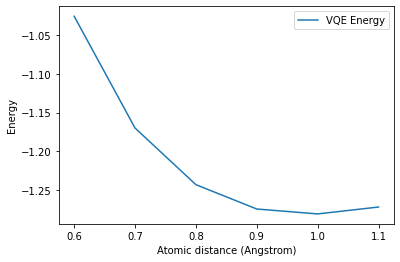

In [21]:
#plt.plot(distances, exact_energies, label="Numpy Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
#plt.ylim([-1.5, -1.3])
plt.show()

Viene letto il file file.txt contenente energie e distanze già calcolate, se sonos tate analizzate nuove distanze le scrive in append alla fine.

In [10]:
with open('file.txt') as f:
    #w, h = [int(x) for x in next(f).split()] # read first line
    distanze_energie = []
    for line in f: # read rest of lines
        w,h=[float(x) for x in line.split()]
        distanze_energie.append((w,h))
f=open('file.txt', 'w+')
i = -1
for dist in distances:
    i=i+1
    if (dist,vqe_energies[i]) not in distanze_energie:
        distanze_energie.append((dist, vqe_energies[i]))
distanze_energie.sort(key=lambda pair: pair[0])
for i in distanze_energie:
    f.write(str(i[0]) + " " + str(i[1]) + "\n")
f.close()

Viene disegnato il grafico di quanto presente nel file file.txt

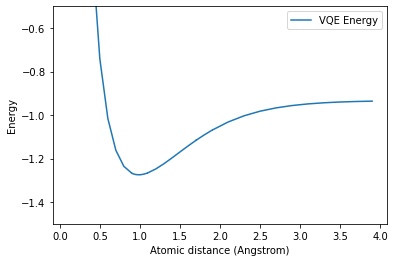

Energia minima: -1.2744224915445381 a 0.9900000000000001 A


In [46]:
f=open('file.txt')
    #w, h = [int(x) for x in next(f).split()] # read first line
distanze = []
energie = []
min = 100
mindist = 0
for line in f: # read rest of lines
    w,h=[float(x) for x in line.split()]
    distanze.append(w)
    energie.append(h) 
    if h < min:
        min = h
        mindist = w
plt.plot(distanze, energie, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.ylim([-1.5, -0.5])
plt.show()
print("Energia minima: " + str(min) + " a " + str(mindist) + " A")

In [50]:
#la distanza di legame dovrebbe essere 1.65 a0
1.65*0.53 #in Angstrom sono circa 0.87

0.8744999999999999

In [33]:
-3.4378452661896883+2.267902332514286

-1.1699429336754021

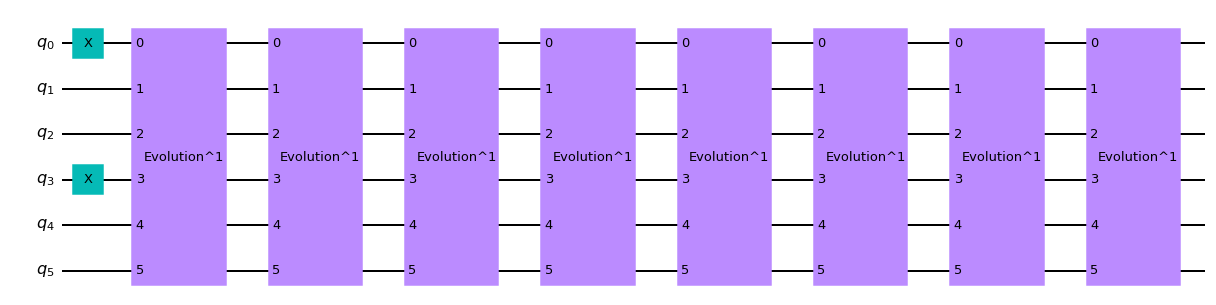

In [36]:
circuit.draw(output='mpl')

In [32]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(result)

{   'algorithm_result': {   'aux_operator_eigenvalues': array([[1.9999999999999913],
       [0.0],
       [0.0],
       [0.0],
       [1.8540261267153375],
       [3.2114279269101065]], dtype=object),
                            'cost_function_evals': 50,
                            'eigenstate': {   '001001': 939,
                                              '010010': 42,
                                              '100100': 43},
                            'eigenvalue': (-2.0501409871938034+0j),
                            'optimal_parameters': {   Parameter(θ[3]): 1.7980221026615364e-08,
                                                      Parameter(θ[7]): -0.20850855513772254,
                                                      Parameter(θ[2]): 0.0002522844019373723,
                                                      Parameter(θ[1]): -1.0864500764499788e-07,
                                                      Parameter(θ[4]): -0.20461191120144964,
                       